In [247]:
import os
import pandas as pd
import numpy as np
import json
import os
import random
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, Normalizer, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
import benchmarks
import visualizations

import time
import IPython

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator, DataGenerator

import transform_functions
# from .benchmarks import bench_k_means, bench_k_medoids
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
# plt.figure(figsize=(15, 12))

In [248]:
# Load dataframe with average weighted value of loan segments
oscwd = os.getcwd()
df_entidad = pd.read_csv(os.path.join(oscwd, "data/GH.txt"), encoding="utf-8",
                            dtype = {
                                    'CODIGO': int, 'ENTIDAD': str, 
                                    'Grupo': float
                                    }
                                    # parse_dates=['Periodo'],
                            )
drop_ent = list(df_entidad["CODIGO"][df_entidad["Grupo"]==8.0])
drop_append = [143, 158, 384, 45030]
drop_ent = drop_ent + drop_append

In [249]:
%%capture cap --no-stderr
print(f"banks_dropped {drop_ent}")

In [250]:
%%capture cap --no-stderr
with open('output/output.txt', 'w') as f:
    f.write(str(cap))

In [251]:
with open("data/kpi.json", "r") as kpi_json:
    kpi_list = json.load(kpi_json)
list_kpis_paper = ["business_loans_assets", "asset_tot_asset", "exp_assets"]
data_kpis = pd.read_csv("data/kpis.csv")
drop_ind = list_kpis_paper
data_kpis = data_kpis[data_kpis["ind"].isin(drop_ind)]
data_kpis = data_kpis[~data_kpis["ent"].isin(drop_ent)]
kpis = data_kpis[data_kpis["ind"].isin(drop_ind)]["ind"].unique()

In [252]:
%%capture cap --no-stderr
print(f"using_kpis {kpis}")

In [253]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

The following columns were dropped: []


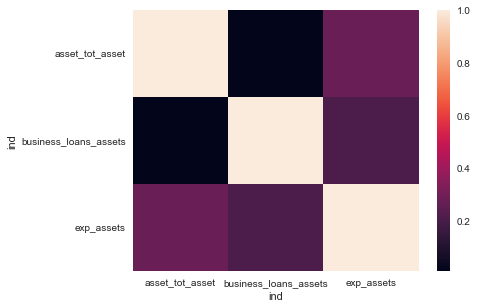

In [254]:
start = 2007
end = 2017
data = transform_functions.get_mean_pivot_table(data_kpis, 0, 2, 1, 3, start, end)
df_corr, data = benchmarks.find_and_drop_correlated_features(data, labels_col="ent", threshold=0.7, drop=True, plot=True)

In [255]:
%%capture cap --no-stderr
df_corr, data = benchmarks.find_and_drop_correlated_features(data, labels_col="ent", threshold=0.7, drop=True, plot=True)
print(f"data_from {start} data_until {end} ")
print("data_not_scaled")
print(data)
print("correlations_matrix")
print(df_corr)

In [256]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

Text(0.5, 1.0, 'Boxplot --- Data not scaled')

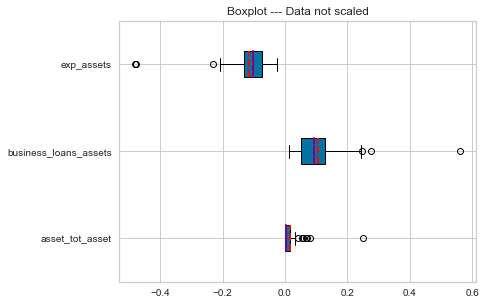

In [257]:
df_describe = data.iloc[:,1:].describe() # .to_excel(writer, sheet_name=f"describe_{s}")
fig, ax = plt.subplots()
ax.boxplot(data[data.columns[1:]], vert=False, showmeans=True, meanline=True,
        labels=data.columns[1:], patch_artist=True,
        medianprops={'linewidth': 2, 'color': 'purple'},
        meanprops={'linewidth': 2, 'color': 'red'})
plt.title(f"Boxplot --- Data not scaled")
#display(df_describe)

In [258]:
%%capture cap --no-stderr
print("describe_not_scaled")
print(df_describe)

In [259]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [260]:
# benchmarks.benchmark_scaling_and_oultlier_methods(data, labels_col="ent", plot=True)

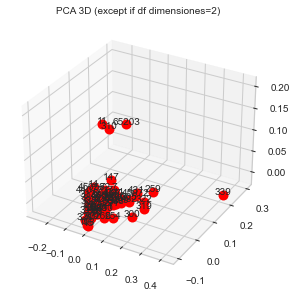

QuantileTransformer(n_quantiles=10, output_distribution='normal') Local Outlier Factor
Droppped the following samples: [11, 269, 310, 312, 339, 65203]


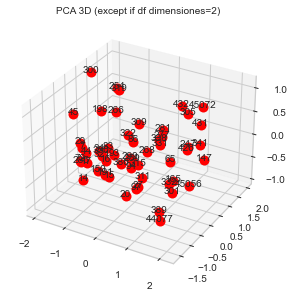

In [261]:
visualizations.plot_3d(data, labels_col="ent")
scaler = 6
algorithm = 6
drop = True
df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=scaler, algorithm=algorithm, drop=drop).reset_index()
df = df.drop(columns="index")
visualizations.plot_3d(df, labels_col="ent")

In [262]:
%%capture cap --no-stderr
df = benchmarks.drop_outliers(data=data, labels_col="ent", scaler=scaler, algorithm=algorithm, drop=drop).reset_index()
df = df.drop(columns="index")

In [263]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

Text(0.5, 1.0, 'Boxplot --- Data scaled')

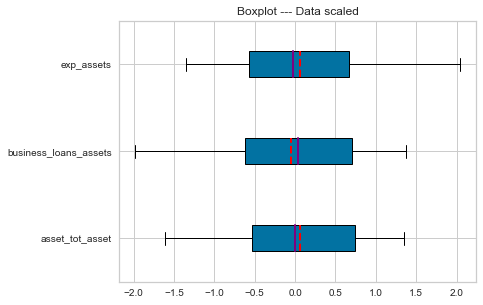

In [264]:
df_describe = df.iloc[:,1:].describe() # .to_excel(writer, sheet_name=f"describe_{s}")
fig, ax = plt.subplots()
ax.boxplot(df[data.columns[1:]], vert=False, showmeans=True, meanline=True,
        labels=df.columns[1:], patch_artist=True,
        medianprops={'linewidth': 2, 'color': 'purple'},
        meanprops={'linewidth': 2, 'color': 'red'})
plt.title(f"Boxplot --- Data scaled")
#display(df_describe)

In [265]:
%%capture cap --no-stderr
print("describe_scaled")
print(df_describe)

In [266]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

In [267]:
# df = data
(n_sample, n_features), n_digits = df.shape, 5
print(f"digits: {n_digits}, samples: {n_sample}, features: {n_features}")

digits: 5, samples: 54, features: 4


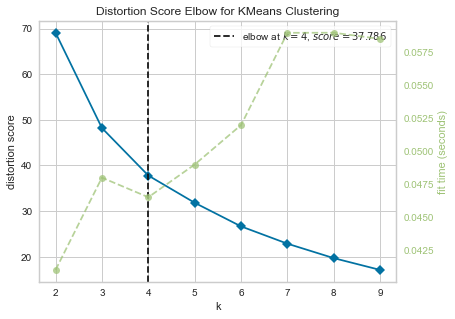

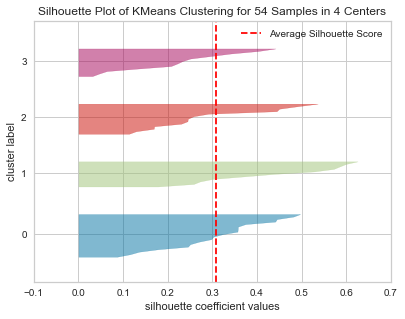

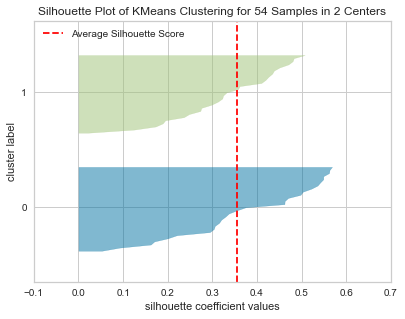

<Figure size 460.8x345.6 with 0 Axes>

In [268]:
init_list = ["random", "k-means++"]
algorithm_list = ["lloyd", "elkan"]
params = {
    'algorithm': algorithm_list[1], 
    'copy_x': True, 
    'init': init_list[1], 
    'max_iter': 1000, 
    'n_clusters': 50, 
    'n_init': 10, 
    'random_state': None, 
    'tol': 0.0001, 
    'verbose': 0
}
df_scores = benchmarks.elbow_optimal_k(df, labels_col="ent", model="kmeans", params=params, max_k=10)
# display(df_scores)

'''fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_scores["k"], df_scores["inertia"], 'g-')
ax2.plot(df_scores["k"], df_scores["calinski_harabasz_score"], 'b-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('inertia', color='g')
ax2.set_ylabel('calinski_harabasz_scorea', color='b')

# plt.show()
# plt.plot(df_scores["k"], df_scores["inertia"])
plt.show()
plt.clf()'''

'''# Fit PCA with 2 components
pca = PCA(n_components=2).fit_transform(df.iloc[:,1:].to_numpy())
# Visualize the data
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(pca[:, 0], pca[:, 1], x="PCA1", y="PCA2")'''

# Instantiate the clustering model and visualizer
model = KMeans().set_params(**params)
kelbow_model = KElbowVisualizer(model, k=(2,10))

kelbow_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
kelbow_model.show()                               # Finalize and render the figure
plt.clf()

elbow = kelbow_model.elbow_value_
params["n_clusters"] = elbow

model = KMeans().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')
silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show()                               # Finalize and render the figure
plt.clf()
y_pred = model.fit_predict(df.iloc[:,1:].to_numpy())
df_y_pred = pd.DataFrame(y_pred, columns=["k_pred"])
df_pred_elbow = pd.concat([df, df_y_pred], axis=1)
df_elbow_centers = pd.DataFrame(model.cluster_centers_, index=range(model.cluster_centers_.shape[0]))

silhouette_k = df_scores["k"].iloc[df_scores["silhouette_score"].idxmax()]
params["n_clusters"] = silhouette_k
model = KMeans().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')
silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show()                               # Finalize and render the figure
plt.clf()
y_pred = model.fit_predict(df.iloc[:,1:].to_numpy())
df_y_pred = pd.DataFrame(y_pred, columns=["k_pred"])
df_pred_silhouette = pd.concat([df, df_y_pred], axis=1)
df_silhouette_centers = pd.DataFrame(model.cluster_centers_, index=range(model.cluster_centers_.shape[0]))

In [269]:
elbow_centers = PCA(n_components=2).fit_transform(df_elbow_centers)
df_elbow_centers = pd.DataFrame(elbow_centers, index=range(elbow_centers.shape[0]))
silhouette_centers = PCA(n_components=2).fit_transform(df_silhouette_centers)
df_silhouette_centers = pd.DataFrame(silhouette_centers, index=range(silhouette_centers.shape[0]))
df_pca = PCA(n_components=2).fit_transform(df.iloc[:,1:])
df_pca = pd.DataFrame(df_pca, columns=["pca1", "pca2"])
df_pca = pd.concat([df, df_pca], axis=1).iloc[:,[0,-2,-1]]

In [270]:
%%capture cap --no-stderr
print(df_scores)
print("k_pred_elbow")
print(df_pred_elbow[["ent", "k_pred"]].sort_values(by=["k_pred", "ent"]))
print("k_pred_silhouette")
print(df_pred_silhouette[["ent", "k_pred"]].sort_values(by=["k_pred", "ent"]))
print("elbow_centers")
print(df_elbow_centers)
print("silhouette_centers")
print(df_silhouette_centers)
print("df_pca")
print(df_pca)

In [271]:
%%capture cap --no-stderr
with open('output/output.txt', 'a') as f:
    f.write(str(cap))

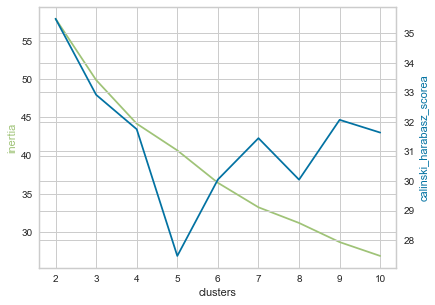

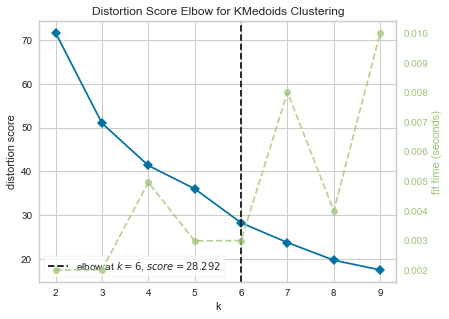

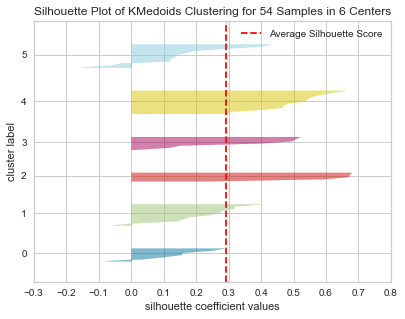

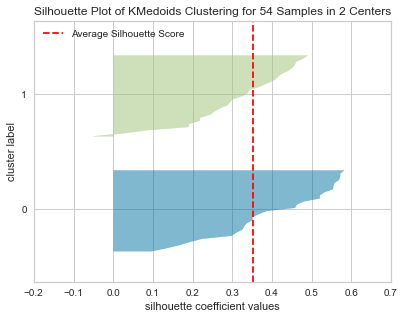

<AxesSubplot:title={'center':'Silhouette Plot of KMedoids Clustering for 54 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [272]:
init_list = ["random", "heuristic", "k-medoids++", "build"]
method_list = ["alternate", "pam"]
params = {
    'init': init_list[2],
    'max_iter': 1000,
    'method': method_list[1],
    'metric': 'euclidean',
    'n_clusters': 8,
    'random_state': None
 }
df_scores = benchmarks.elbow_optimal_k(df, labels_col="ent", model="kmedoids", params=params, max_k=10)
#display(df_scores)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_scores["k"], df_scores["inertia"], 'g-')
ax2.plot(df_scores["k"], df_scores["calinski_harabasz_score"], 'b-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('inertia', color='g')
ax2.set_ylabel('calinski_harabasz_scorea', color='b')

# plt.show()
# plt.plot(df_scores["k"], df_scores["inertia"])
plt.show()
plt.clf()

'''# Fit PCA with 2 components
pca = PCA(n_components=2).fit_transform(df.iloc[:,1:].to_numpy())
# Visualize the data
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(pca[:, 0], pca[:, 1], x="PCA1", y="PCA2")'''

# Instantiate the clustering model and visualizer
model = KMedoids().set_params(**params)
kelbow_model = KElbowVisualizer(model, k=(2,10))

kelbow_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
kelbow_model.show()                               # Finalize and render the figure

elbow = kelbow_model.elbow_value_
params["n_clusters"] = elbow
model = KMedoids().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')

silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show()

y_pred = model.fit_predict(df.iloc[:,1:].to_numpy())
df_y_pred = pd.DataFrame(y_pred, columns=["elbow_k_pred"])
df_pred = pd.concat([df, df_y_pred], axis=1)
#display(df_pred[["ent", "elbow_k_pred"]])

silhouette_k = df_scores["k"].iloc[df_scores["silhouette_score"].idxmax()]
params["n_clusters"] = silhouette_k
model = KMedoids().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')
silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show()                               # Finalize and render the figure

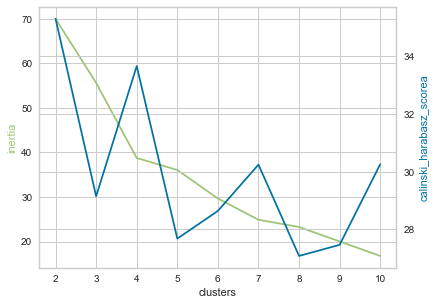

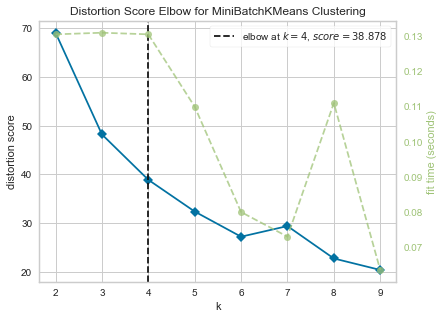

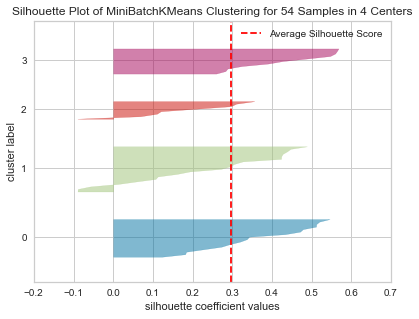

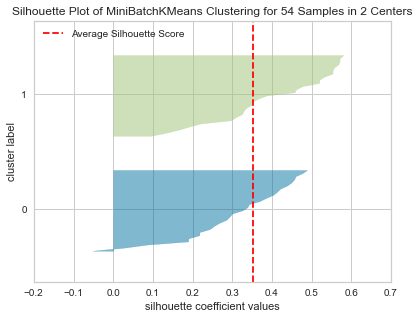

<AxesSubplot:title={'center':'Silhouette Plot of MiniBatchKMeans Clustering for 54 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [273]:
init_list = ["random", "k-means++"]
algorithm_list = ["lloyd", "elkan"]
params = {
    'batch_size': 1024,
    'compute_labels': True,
    'init': init_list[0],
    'init_size': None,
    'max_iter': 1000,
    'max_no_improvement': 10,
    'n_clusters': 8,
    'n_init': 10,
    'random_state': None,
    'reassignment_ratio': 0.01,
    'tol': 0.0,
    'verbose': 0
}
df_scores = benchmarks.elbow_optimal_k(df, labels_col="ent", model="minibatch_kmeans", params=params, max_k=10)
# display(df_scores)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_scores["k"], df_scores["inertia"], 'g-')
ax2.plot(df_scores["k"], df_scores["calinski_harabasz_score"], 'b-')

ax1.set_xlabel('clusters')
ax1.set_ylabel('inertia', color='g')
ax2.set_ylabel('calinski_harabasz_scorea', color='b')

# plt.show()
# plt.plot(df_scores["k"], df_scores["inertia"])
plt.show()
plt.clf()

'''# Fit PCA with 2 components
pca = PCA(n_components=2).fit_transform(df.iloc[:,1:].to_numpy())
# Visualize the data
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(pca[:, 0], pca[:, 1], x="PCA1", y="PCA2")'''

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans().set_params(**params)
kelbow_model = KElbowVisualizer(model, k=(2,10))

kelbow_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
kelbow_model.show()                               # Finalize and render the figure

elbow = kelbow_model.elbow_value_
params["n_clusters"] = elbow
model = MiniBatchKMeans().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')

silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show()

y_pred = model.fit_predict(df.iloc[:,1:].to_numpy())
df_y_pred = pd.DataFrame(y_pred, columns=["elbow_k_pred"])
df_pred = pd.concat([df, df_y_pred], axis=1)
# display(df_pred[["ent", "elbow_k_pred"]])

silhouette_k = df_scores["k"].iloc[df_scores["silhouette_score"].idxmax()]
params["n_clusters"] = silhouette_k
model = MiniBatchKMeans().set_params(**params)
silhouette_model = SilhouetteVisualizer(model, colors='yellowbrick')
silhouette_model.fit(df.iloc[:,1:].to_numpy())        # Fit the data to the visualizer
silhouette_model.show() 

For n_clusters = 4 The average silhouette_score is : 2    0.3156
Name: silhouette_score, dtype: float64
2    [0.4944457400054279, -0.039704126094562864, 0....
Name: silhouette_samples, dtype: object


IndexError: Boolean index has wrong length: 4 instead of 1

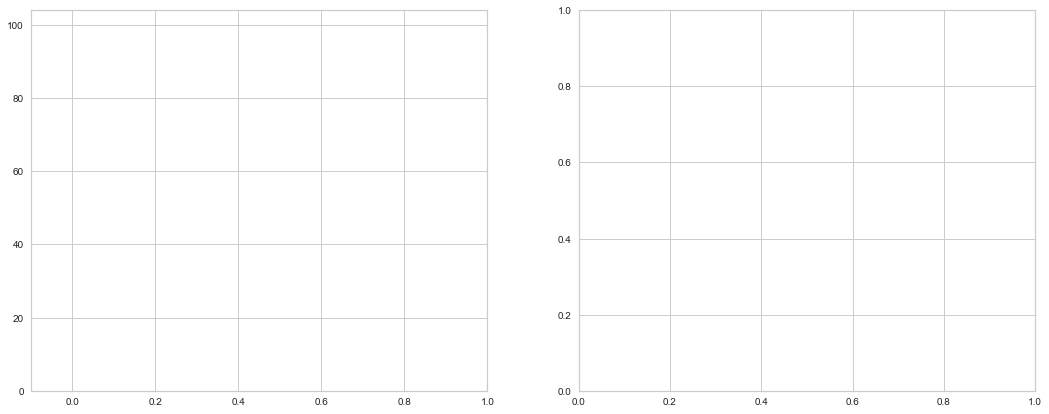

In [274]:
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(df) + (elbow + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
# clusterer = model # KMeans(n_clusters=n_clusters, n_init=100, max_iter=10000, algorithm="elkan")
# cluster_labels = clusterer.fit_predict(df.iloc[:,1:].to_numpy())

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = df_scores["silhouette_score"].loc[df_scores["k"]==elbow]
print(
    "For n_clusters =",
    elbow,
    "The average silhouette_score is :",
    silhouette_avg,
)

labels_k = df_pred.elbow_k_pred.unique()

# Compute the silhouette scores for each sample
sample_silhouette_values = df_scores["silhouette_samples"].loc[df_scores["k"]==elbow]
print(sample_silhouette_values)

y_lower = 10
for i in range(elbow):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[df_pred.elbow_k_pred.unique() == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / elbow)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

pca = PCA(n_components=2).fit_transform(df.iloc[:,1:].to_numpy())

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(labels_k.astype(float) / elbow)
ax2.scatter(
    pca[:, 0], pca[:, 1], marker=".", s=30, lw=1, alpha=0.7, c=colors, edgecolor=colors
)

# Labeling the clusters
centers = model.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=75, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % elbow,
    fontsize=14,
    fontweight="bold",
)

plt.show()